# k-means perfil de riesgo clientes no existentes


In [ ]:
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
from sqlalchemy import select
from sqlalchemy import text
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys

In [ ]:
# Define tus credenciales locales aquí.
# Asegúrate de que las bases de datos 'gold' existan en tu MySQL ejecutando el notebook
DB_USER = "root"
DB_PASS = "juanMySQL0513." # Reemplaza con tu contraseña
DB_HOST = "localhost"
DB_PORT = "3306"

# Motores para cada capa
try:
    engine_gold = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/gold")
    print("Motores de base de datos configurados correctamente.")
except Exception as e:  
    print(f"Error al configurar los motores de base de datos: {e}")
    sys.exit(1)

In [ ]:
df=pd.read_sql_query("select*from risk_level_data",engine_gold)

2025-08-05 18:27:38,625 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2025-08-05 18:27:38,627 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:27:38,631 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2025-08-05 18:27:38,632 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:27:38,634 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2025-08-05 18:27:38,636 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:27:38,638 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-08-05 18:27:38,640 INFO sqlalchemy.engine.Engine select*from risk_level_data
2025-08-05 18:27:38,640 INFO sqlalchemy.engine.Engine [raw sql] {}


2025-08-05 18:27:48,530 INFO sqlalchemy.engine.Engine ROLLBACK


In [325]:
df_original=df.copy()

## analisis de feautures

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FLAG_OWN_CAR         307511 non-null  object 
 1   FLAG_OWN_REALTY      307511 non-null  object 
 2   CNT_CHILDREN         307511 non-null  int64  
 3   AMT_INCOME_TOTAL     307511 non-null  float64
 4   AMT_CREDIT           307511 non-null  float64
 5   NAME_INCOME_TYPE     307511 non-null  object 
 6   NAME_EDUCATION_TYPE  307511 non-null  object 
 7   NAME_FAMILY_STATUS   307511 non-null  object 
 8   NAME_HOUSING_TYPE    307511 non-null  object 
 9   YEARS_BIRTH          307511 non-null  int64  
 10  DAYS_EMPLOYED        307511 non-null  int64  
 11  OWN_CAR_AGE          307511 non-null  float64
 12  OCCUPATION_TYPE      307511 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 30.5+ MB


In [327]:
df_int=df.select_dtypes(include=["number"])
df_int.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE
count,307511.000000,3.075110e+05,3.075110e+05,307511.000000,307511.000000,307511.000000
mean,0.417052,1.687979e+05,5.990260e+05,43.435968,1954.848123,4.101879
std,0.722121,2.371231e+05,4.024908e+05,11.954593,2307.068896,9.009514
min,0.000000,2.565000e+04,4.500000e+04,20.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,34.000000,289.000000,0.000000
50%,0.000000,1.471500e+05,5.135310e+05,43.000000,1213.000000,0.000000
75%,1.000000,2.025000e+05,8.086500e+05,53.000000,2760.000000,5.000000
max,19.000000,1.170000e+08,4.050000e+06,69.000000,17912.000000,91.000000


In [328]:
colums_int=df_int.columns
colums_int

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'YEARS_BIRTH',
       'DAYS_EMPLOYED', 'OWN_CAR_AGE'],
      dtype='object')

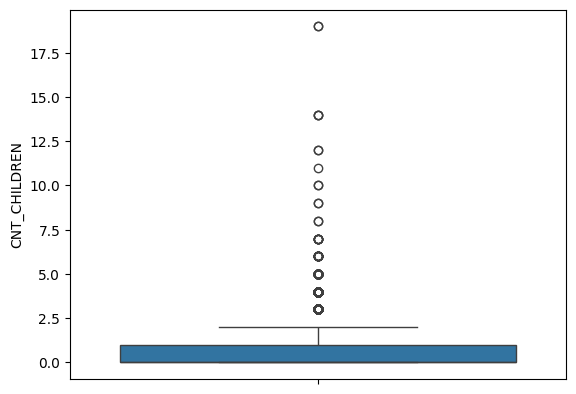

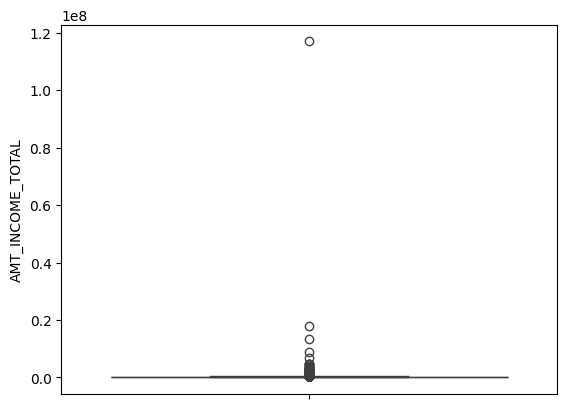

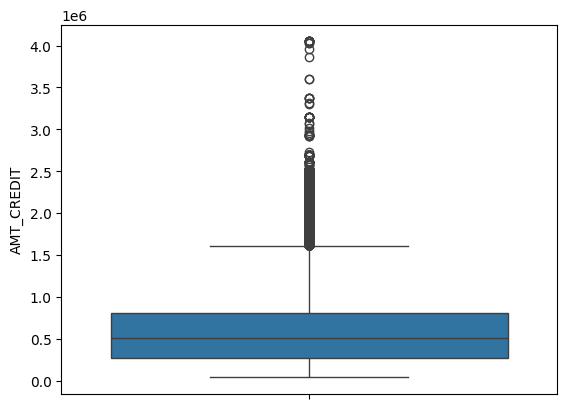

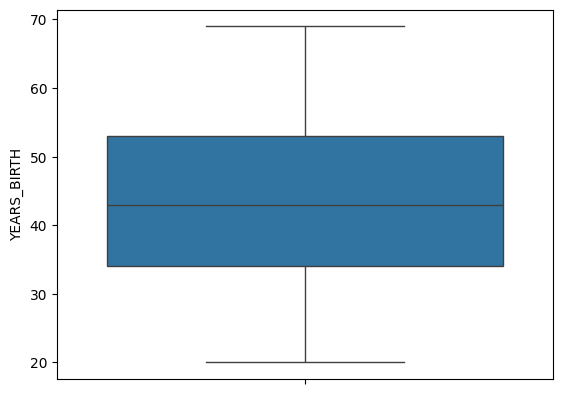

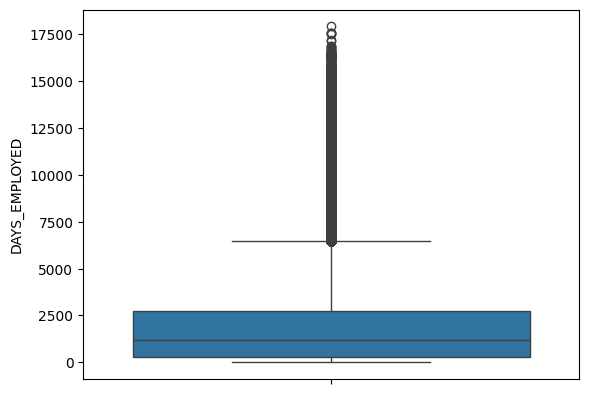

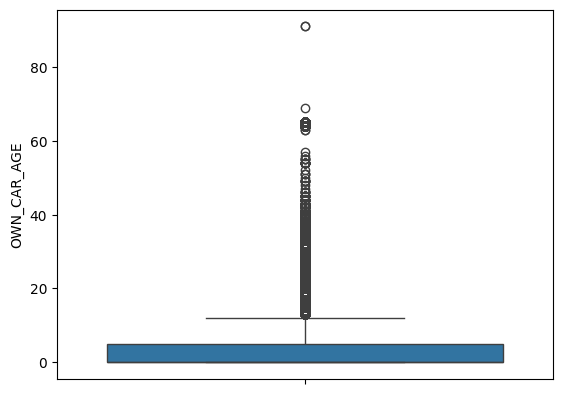

In [329]:
for colum in colums_int:
    sns.boxplot(df_int[colum])
    plt.show()

In [330]:
colums_ob=df.select_dtypes("object").columns

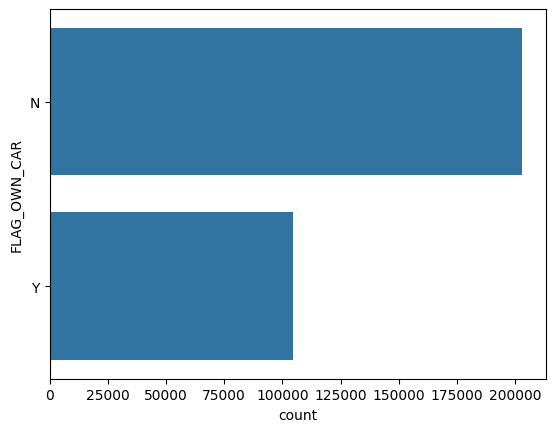

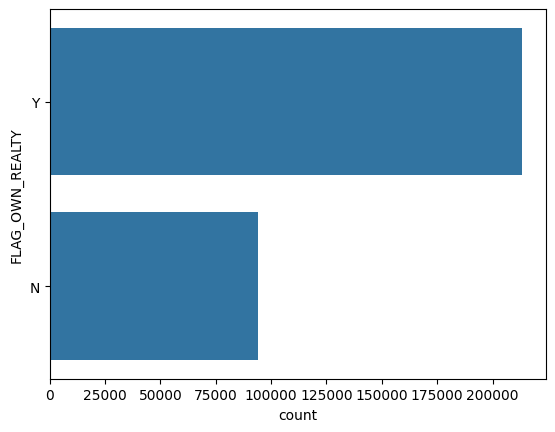

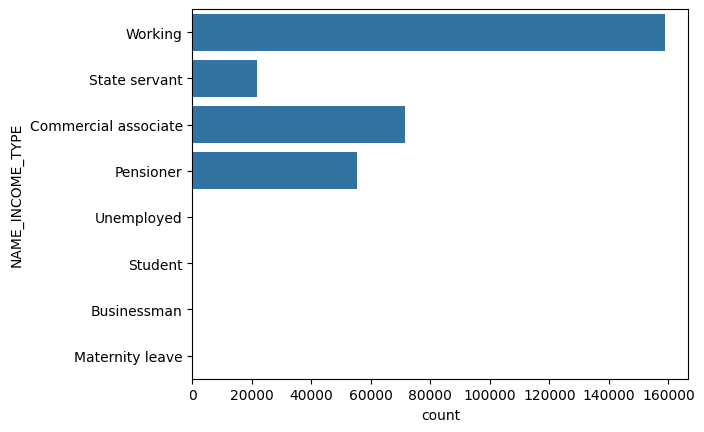

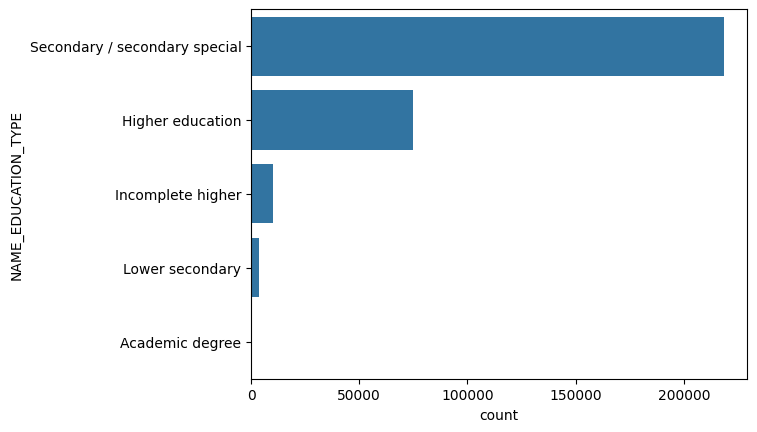

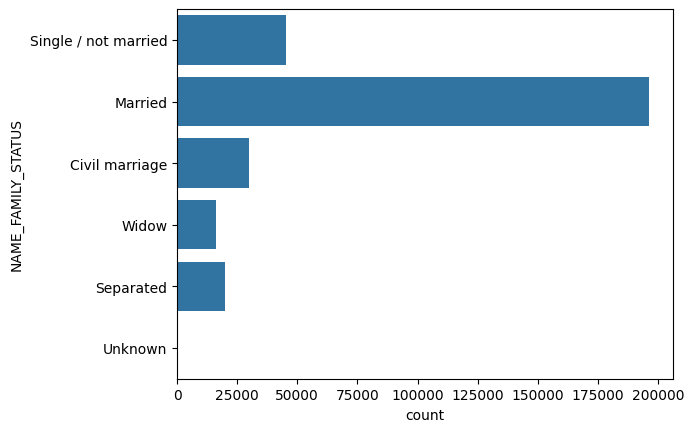

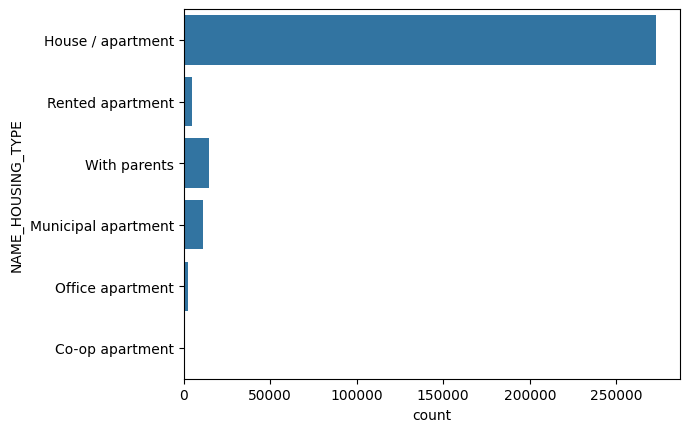

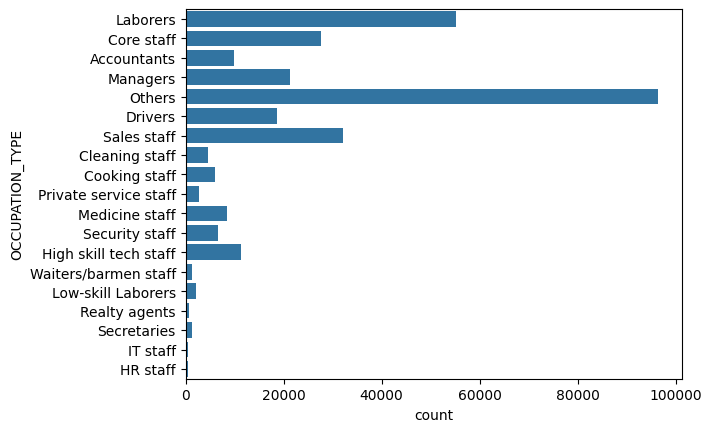

In [331]:
for colum in colums_ob:
    sns.countplot(y=colum, data=df)
    plt.show()

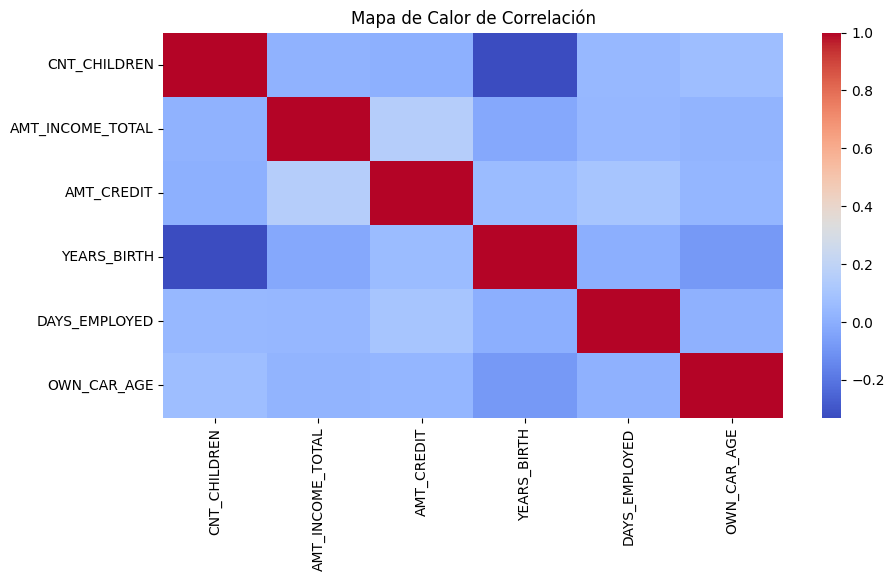

In [332]:
# Calcula la matriz de correlación
correlation_matrix = df_int.corr()

# Crea el mapa de calor
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm') # annot=True si no tienes demasiadas variables
plt.title('Mapa de Calor de Correlación')
plt.show()

## transformacion de datos

In [333]:

for colum in colums_int:
    #Transformacion logaritmica
    df[colum] = np.log1p(df[colum])
    # Capping
    p1 = df[colum].quantile(0.01)
    p99 = df[colum].quantile(0.99)
    df[colum] = df[colum].clip(lower=p1, upper=p99)
    

    


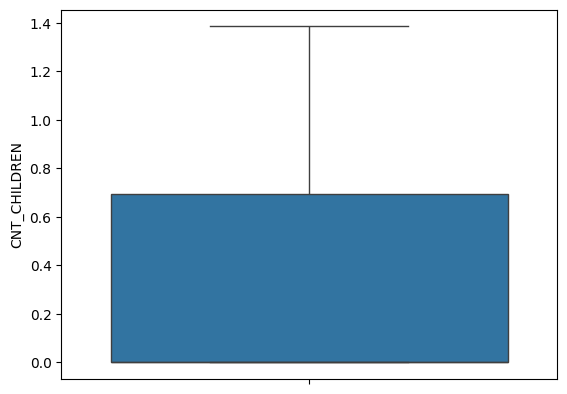

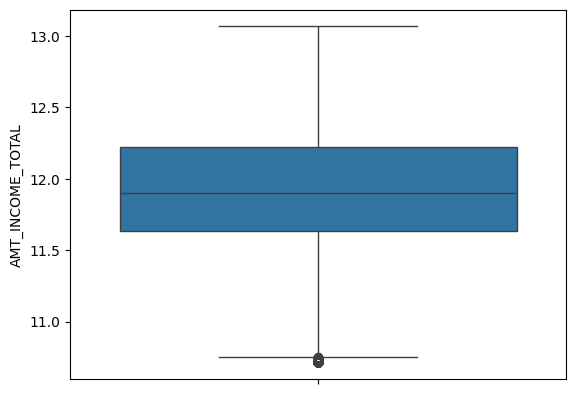

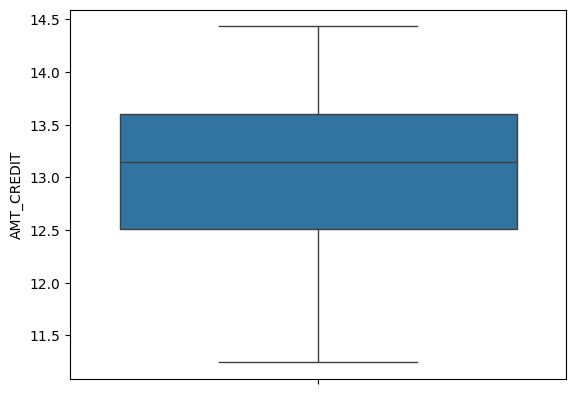

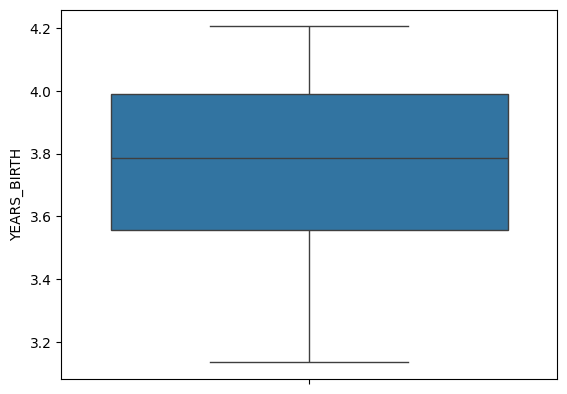

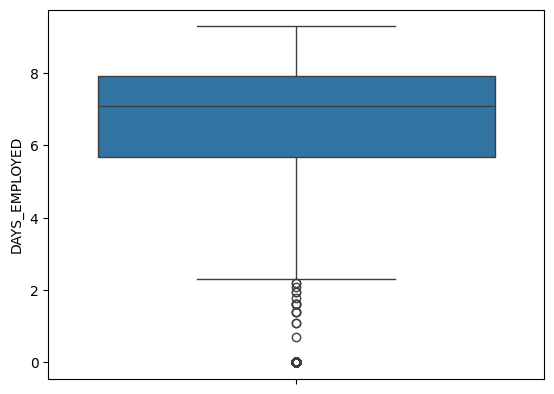

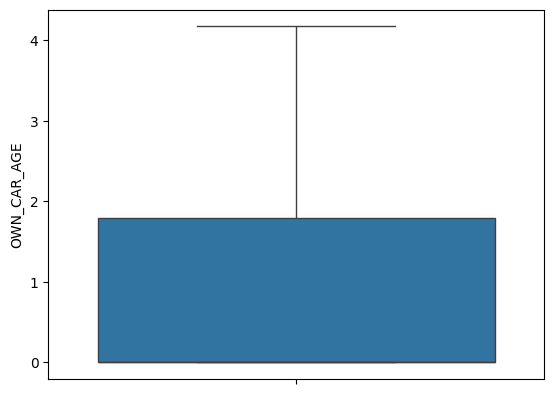

In [334]:
for colum in colums_int:
    sns.boxplot(df[colum])
    plt.show()

In [335]:
df['NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].replace({
    'Unemployed': 'others',
    'Student': 'others',
    'Businessman': 'others',
    'Maternity leave': 'others'
})


In [336]:

# Calcular el umbral (1% del total de filas)
umbral = len(df) * 0.01

# Recorrer cada columna y reemplazar las categorías de baja frecuencia
for columna in colums_ob:
    # 1. Obtener frecuencias
    frecuencias = df[columna].value_counts()
    
    # 2. Detectar categorías menos frecuentes
    categorias_baja_frecuencia = frecuencias[frecuencias < umbral].index.tolist()
    
    # 3. Reemplazar por un nombre genérico
    df[columna] = df[columna].replace(categorias_baja_frecuencia, 'Less common')


In [337]:
df_train = pd.get_dummies(df, columns=colums_ob)
df_train=df_train.astype(int)

In [338]:
scaler=StandardScaler()
data_train=scaler.fit_transform(df_train)

In [339]:
df_train

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,YEARS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Less common,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Others,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff
0,0,12,12,3,6,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,12,14,3,7,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,11,11,3,5,3,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
3,0,11,12,3,8,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,11,13,4,8,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,11,12,3,5,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
307507,0,11,12,4,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
307508,0,11,13,3,8,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
307509,0,12,12,3,8,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


## model

In [340]:
k=KMeans(n_clusters=3,random_state=42)
k.fit(data_train)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [341]:
df_original["TARGET"]=k.labels_

In [342]:
df_original["TARGET"].value_counts()

TARGET
1    179626
2     93245
0     34640
Name: count, dtype: int64

In [343]:
df_original.to_sql("risk_level_data",engine,if_exists="replace",schema="gold",index=False)

2025-08-05 18:32:47,390 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-08-05 18:32:47,481 INFO sqlalchemy.engine.Engine DESCRIBE `gold`.`risk_level_data`
2025-08-05 18:32:47,483 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:32:47,522 INFO sqlalchemy.engine.Engine DESCRIBE `gold`.`risk_level_data`
2025-08-05 18:32:47,522 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:32:47,526 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `gold`
2025-08-05 18:32:47,526 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:32:47,537 INFO sqlalchemy.engine.Engine SHOW FULL TABLES FROM `gold`
2025-08-05 18:32:47,539 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:32:47,565 INFO sqlalchemy.engine.Engine SHOW CREATE TABLE `gold`.`risk_level_data`
2025-08-05 18:32:47,571 INFO sqlalchemy.engine.Engine [raw sql] {}
2025-08-05 18:32:47,582 INFO sqlalchemy.engine.Engine 
DROP TABLE gold.risk_level_data
2025-08-05 18:32:47,584 INFO sqlalchemy.engine.Engine [no key 0.0022

307511

## Interpretacion de las clasificaciones

In [289]:
colums_ob

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')

In [ ]:
# Iteramos sobre cada columna categórica para ver su distribución por clúster
for col in colums_ob:
    print(f"\n--- Distribución de '{col}' por Clúster ---")
    # value_counts(normalize=True) nos da las proporciones (porcentajes)
    # unstack() lo formatea en una tabla fácil de leer
    perfil_categorico = df_original.groupby('TARGET')[col].value_counts(normalize=True).unstack(fill_value=0)
    print(perfil_categorico)


--- Distribución de 'FLAG_OWN_CAR' por Clúster ---


FLAG_OWN_CAR         N         Y
target                          
0             0.682737  0.317263
1             0.998040  0.001960
2             0.000000  1.000000

--- Distribución de 'FLAG_OWN_REALTY' por Clúster ---
FLAG_OWN_REALTY         N         Y
target                             
0                0.592610  0.407390
1                0.265424  0.734576
2                0.278771  0.721229

--- Distribución de 'NAME_INCOME_TYPE' por Clúster ---
NAME_INCOME_TYPE  Businessman  Commercial associate  Maternity leave  \
target                                                                 
0                    0.000000              0.257361         0.000000   
1                    0.000011              0.209903         0.000022   
2                    0.000086              0.268089         0.000011   

NAME_INCOME_TYPE  Pensioner  State servant   Student  Unemployed   Working  
target                                                                      
0                  0.086172  

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Creamos un diccionario para mapear el número del clúster a la etiqueta de riesgo
mapa_riesgo = {
    0: 'Riesgo Alto',
    1: 'Riesgo Medio',
    2: 'Riesgo Bajo'
}
df_original["TARGET"].replace(mapa_riesgo)


0         Riesgo Medio
1         Riesgo Medio
2          Riesgo Bajo
3         Riesgo Medio
4         Riesgo Medio
              ...     
307506     Riesgo Alto
307507    Riesgo Medio
307508    Riesgo Medio
307509    Riesgo Medio
307510    Riesgo Medio
Name: target, Length: 307511, dtype: object

## Model clasificacion

In [292]:
df_original

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,YEARS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,target
0,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,25,637,0.0,Laborers,1
1,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,45,1188,0.0,Core staff,1
2,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,52,225,26.0,Laborers,2
3,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,52,3039,0.0,Laborers,1
4,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,54,3038,0.0,Core staff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,N,N,0,157500.0,254700.0,Working,Secondary / secondary special,Separated,With parents,25,236,0.0,Sales staff,0
307507,N,Y,0,72000.0,269550.0,Pensioner,Secondary / secondary special,Widow,House / apartment,56,0,0.0,Others,1
307508,N,Y,0,153000.0,677664.0,Working,Higher education,Separated,House / apartment,41,7921,0.0,Managers,1
307509,N,Y,0,171000.0,370107.0,Commercial associate,Secondary / secondary special,Married,House / apartment,32,4786,0.0,Laborers,1


In [307]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

In [294]:
categoricas=df_original.select_dtypes("object").columns

In [310]:
df_train=df_original.copy()

In [312]:
for colum in categoricas:
    freq_map = df_original[colum].value_counts().to_dict()
    df_train[colum] = df[colum].map(freq_map)

In [295]:
df_train = pd.get_dummies(df_original, columns=categoricas)
df_train=df_train.astype(int)

In [313]:
X=df_train.drop("target",axis=1)
y=df_train["target"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [314]:
model = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [317]:
# 7. Evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9998048875664601

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7024
           1       1.00      1.00      1.00     35968
           2       1.00      1.00      1.00     18511

    accuracy                           1.00     61503
   macro avg       1.00      1.00      1.00     61503
weighted avg       1.00      1.00      1.00     61503



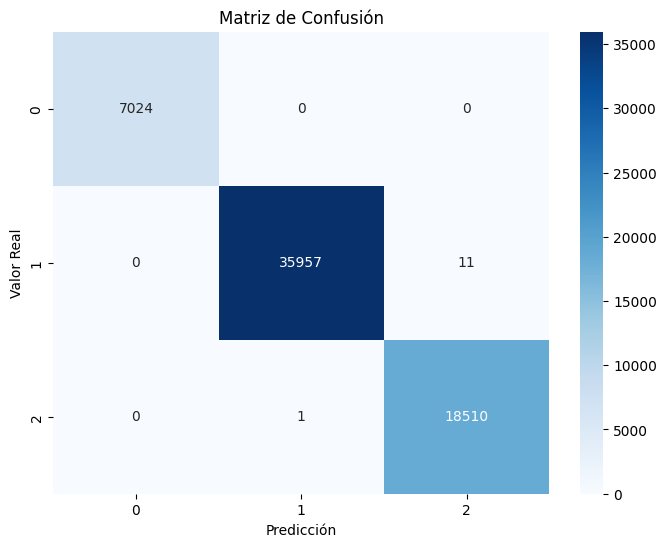

In [315]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

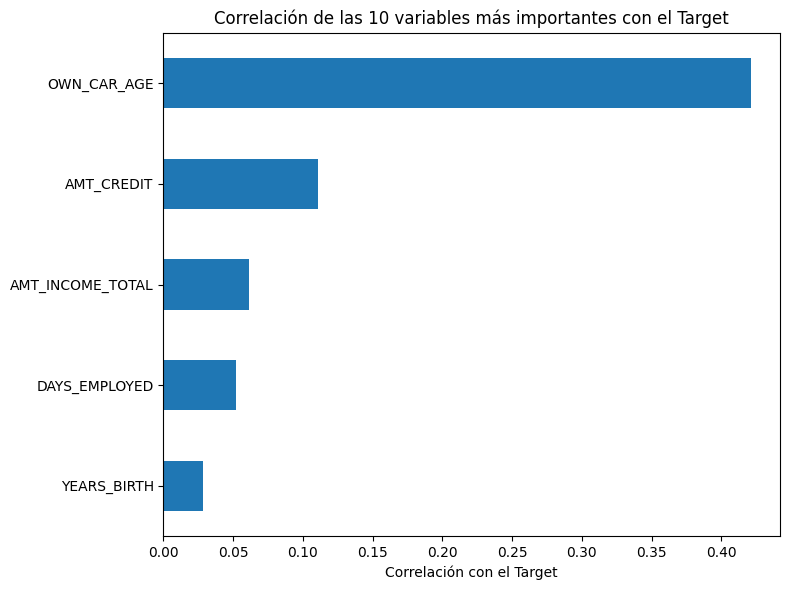

In [320]:
# 1. Importancia de características
importances = model.feature_importances_
features = X.columns

# 2. Crear DataFrame de importancias
feat_importance = pd.DataFrame({
    "feature": features,
    "importance": importances
})

# 3. Seleccionar las 10 más importantes
top_features = feat_importance.sort_values(by="importance", ascending=False).head(10)

# 4. Extraer esas columnas del dataset original
top_vars = top_features["feature"].tolist()
df_top = df_original[top_vars + ["target"]]  # Asegúrate de poner el nombre real

# 5. Codificar target si no es numérico
if df_top["target"].dtype == "object":
    df_top["target"] = df_top["target"].astype("category").cat.codes

# 6. Calcular correlación con el target
correlations = df_top.corr(numeric_only=True)["target"].drop("target")

# 7. Mostrar en gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
correlations.sort_values().plot(kind="barh")
plt.xlabel("Correlación con el Target")
plt.title("Correlación de las 10 variables más importantes con el Target")
plt.tight_layout()
plt.show()
